# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções de Custo](#Funções-de-custo)

[Implementação](#Implementação)

[Testes](#Testes)

- [Classificação](#Classificação)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
from utils import plots

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1-y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções de Custo

In [3]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def softmax_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -( y*(1/y_pred) + (1-y)*(1/(1-y_pred)) )
    return -np.mean((y*np.log(y_pred) + (1-y)*np.log(1-y_pred)).sum(axis=1))

# Implementação 

In [4]:
class NeuralNetwork():
    def __init__(self, layers_size, activations, cost_func, learning_rate=1e-3):
        self.layers_size = layers_size
        self.activations = activations
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self._activ_inp = []
        self._activ_out = []
        self.weights = [np.random.randn(out, inp) for inp, out in zip(self.layers_size[:-1], self.layers_size[1:])]
        self.biases = [np.random.randn(1, out) for out in self.layers_size[1:]]
            
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                cost = self.cost_func(y, y_pred)
                print("epoch: {0:=4}/{1} cost: {2:.8f}".format(epoch, epochs, cost))
    
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self._activ_inp, self._activ_out = [], []
        self._activ_out.append(x)
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            y = np.dot(self._activ_out[-1], w.T) + b
            self._activ_inp.append(y)
            self._activ_out.append(activation(y))
        return self._activ_out[-1]
    
    def __backprop(self, y, y_pred):
        self._activ_out.pop()
        
        last_delta = self.cost_func(y, y_pred, derivative=True)
        dweights, dbiases = [], []
        for inp, out, w, activation in zip(self._activ_inp[::-1], self._activ_out[::-1], self.weights[::-1], self.activations[::-1]):
            dactivation = activation(inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, w)
            dweights.append(np.dot(dactivation.T, out))
            dbiases.append(1.0*dactivation.sum(axis=0, keepdims=True))
        
        self.weights = [w - self.learning_rate*dw for w, dw in zip(self.weights, reversed(dweights))]
        self.biases  = [b - self.learning_rate*db for b, db in zip(self.biases, reversed(dbiases))]

# Testes

## Exemplo 1

In [5]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 2, 2], activations=[sigmoid, sigmoid], cost_func=mse, learning_rate=0.5)

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.weights = [w1, w2]
nn.biases = [b1, b2]

nn.fit(x, y, epochs=1, verbose=1)
for w in nn.weights:
    print(w)

epoch:    0/1 cost: 0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


## Classificação

### Porta AND/OR

In [6]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


In [7]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.weights, nn.biases)
print(nn.predict(x))

epoch:    0/5000 cost: 1.55692485
epoch: 1000/5000 cost: 0.04607023
epoch: 2000/5000 cost: 0.03117769
epoch: 3000/5000 cost: 0.02496683
epoch: 4000/5000 cost: 0.02137424
[array([[ 7.27806851,  7.27806851]])] [array([[-11.00463626]])]
[[  1.66241702e-05]
 [  2.35093317e-02]
 [  2.35093317e-02]
 [  9.72118132e-01]]


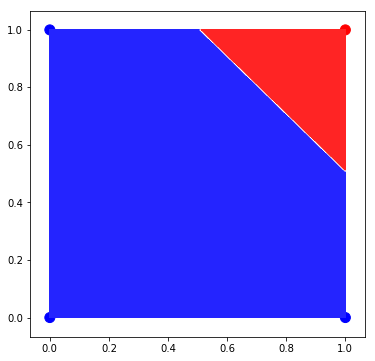

In [8]:
plots.plot_linear_classifier_2d_nn(x, y.ravel(), nn, threshold=0.5)

### Porta XOR

In [9]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


In [13]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 1], activations=[sigmoid, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

epoch:    0/5000 cost: 0.69682621
epoch: 1000/5000 cost: 0.07389234
epoch: 2000/5000 cost: 0.04217096
epoch: 3000/5000 cost: 0.03216656
epoch: 4000/5000 cost: 0.02690249
[[ 0.0244833 ]
 [ 0.9785171 ]
 [ 0.97857307]
 [ 0.02568649]]


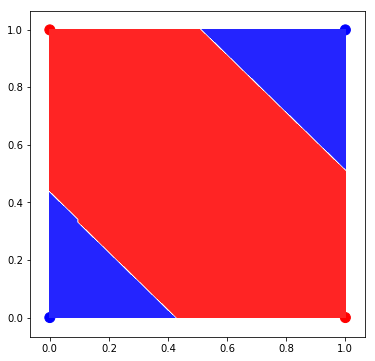

In [14]:
plots.plot_linear_classifier_2d_nn(x, y.ravel(), nn, threshold=0.5)

# Referências